In [56]:
import argparse
import time

import torch
from PIL import Image
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

import models

/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_19167/2427446230.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [86]:
UPSCALE_FACTOR = 2
TEST_MODE = False
IMAGE_NAME = '/Volumes/DataDrive/clim_tif/test/2016-02-12.tif'
MODEL_NAME = '/Volumes/DataDrive/clim_model_runs/epochs/netG_run_10_epoch_7.pth'

In [87]:
# downscale the test image
hr_image = Image.open(IMAGE_NAME)
high_res = np.array(hr_image)

# get the input LR image from output HR image by blurring, cropping, then interpolating
h1,w1 = high_res.shape
blurred = np.zeros_like(high_res)
blurred = gaussian_filter(high_res, sigma = (0.55, 0.55))
half_res = blurred[::2, ::2]

# Code involved in interpolating the blurred image back up to high res resolution
h2,w2 = half_res.shape
x = np.arange(h2)
y = np.arange(w2)
xnew = np.arange(0, h2, h2/h1)
ynew = np.arange(0, w2, w2/w1)
low_res = np.zeros_like(high_res)
f = RectBivariateSpline(x, y, half_res[:, :])
low_res[:, :] = f(xnew, ynew)

Text(0.5, 1.0, 'Low Res Image')

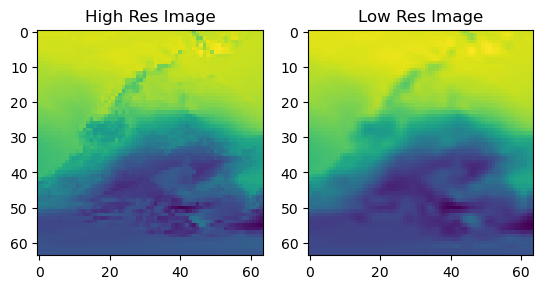

In [88]:
plt.subplot(121)
plt.imshow(high_res)
plt.title('High Res Image')
plt.subplot(122)
plt.imshow(low_res)
plt.title('Low Res Image')
#plt.savefig('/Users/ryaneagan/Desktop/test_output.png')

cost0.03648781776428223s


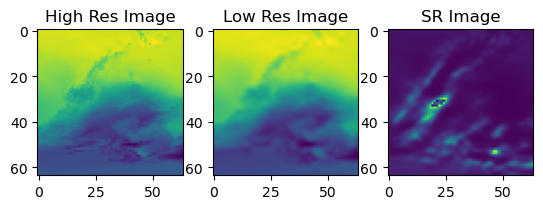

In [90]:

model = models.Generator(1,UPSCALE_FACTOR).eval()

model.load_state_dict(torch.load(MODEL_NAME), strict=False)

image = torch.from_numpy(low_res).unsqueeze(0)

start = time.time()
out = model(image)
elapsed = (time.time() - start)
print('cost' + str(elapsed) + 's')
out_image = ToPILImage()(out[0].data.cpu())
#out_image.save('out_srf_' + str(UPSCALE_FACTOR) + '_' + IMAGE_NAME)

plt.subplot(131)
plt.imshow(high_res)
plt.title('High Res Image')
plt.subplot(132)
plt.imshow(low_res)
plt.title('Low Res Image')
plt.subplot(133)
plt.imshow(out_image)
plt.title('SR Image')
plt.savefig('/Users/ryaneagan/Desktop/test_output.png')

In [64]:
out.shape

torch.Size([1, 1, 64, 64])